# 🛡️ RAKSHAK IDS Model Training
## Train Intrusion Detection System using CICIDS2017 Dataset

This notebook trains a lightweight **XGBoost classifier** for deployment on **Jetson Xavier NX**.

**Dataset:** CICIDS2017 (Canadian Institute for Cybersecurity)

**Output:** Trained model files for RAKSHAK gateway

## 📦 Cell 1: Install Dependencies

In [1]:
!pip install -q kaggle xgboost scikit-learn pandas numpy matplotlib seaborn joblib

## 🔑 Cell 2: Setup Kaggle API

1. Go to https://www.kaggle.com/settings
2. Click "Create New Token" under API
3. Download `kaggle.json`
4. Upload it when prompted below

In [2]:
!pip install kagglehub

## 📥 Cell 3: Download CICIDS2017 Dataset

In [3]:

import kagglehub
import os

print("📥 Downloading CICIDS2017 Dataset using kagglehub...")
# Download latest version
download_root_path = kagglehub.dataset_download("mdalamintalukder/cicids2017")

print(f"✅ Dataset downloaded to: {download_root_path}")

# Search for the actual directory containing CSV files
# The dataset typically extracts into a subfolder like 'MachineLearningCVE' or similar.
actual_data_dir = None
for root, dirs, files in os.walk(download_root_path):
    if any(f.endswith('.csv') for f in files):
        actual_data_dir = root
        break

if actual_data_dir:
    csv_files = [f for f in os.listdir(actual_data_dir) if f.endswith('.csv')]
    print(f"\n📊 Found {len(csv_files)} CSV files in {actual_data_dir}:")
    for f in csv_files:
        print(f"  - {f}")
else:
    print(f"Error: No CSV files found within {download_root_path} or its subdirectories.")
    csv_files = [] # Ensure csv_files is defined even if no CSVs are found

# Set data_dir to the actual directory for later use in load_data
data_dir = actual_data_dir # This global variable will be used by the load_data cell

/home/pavan/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Downloading CICIDS2017 Dataset using kagglehub...
✅ Dataset downloaded to: /home/pavan/.cache/kagglehub/datasets/mdalamintalukder/cicids2017/versions/1

📊 Found 8 CSV files in /home/pavan/.cache/kagglehub/datasets/mdalamintalukder/cicids2017/versions/1/MachineLearningCVE:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv


## 📚 Cell 4: Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [5]:
import xgboost as xgb

# Check if GPU is available (XGBoost 2.0+ syntax)
print(f"XGBoost version: {xgb.__version__}")
gpu_support = xgb.XGBClassifier(tree_method='hist', device='cuda')
print("✅ GPU support is available and configured correctly!")

XGBoost version: 3.1.3
✅ GPU support is available and configured correctly!


In [6]:
!nvidia-smi

Fri Jan 16 13:49:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              1W /   50W |       3MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 📂 Cell 5: Load and Combine CSV Files

In [7]:
from tqdm import tqdm

# ============================================================
# 🔧 CONFIGURATION: Adjust sample size here
# ============================================================
# Set to None to use FULL dataset (may require more RAM)
# Recommended values:
#   - 50000: Quick testing (~5 min training)
#   - 100000: Balanced (current)
#   - 500000: More data, better generalization
#   - None: Full dataset (~2.8M samples, needs 16GB+ RAM)
# ============================================================
SAMPLE_SIZE_PER_FILE = 200000  # Increased for better generalization
# ============================================================

def load_cicids2017(data_dir, sample_size=None):
    """Load all CICIDS2017 CSV files and combine them."""
    if not os.path.exists(data_dir):
        print(f"Error: Data directory '{data_dir}' not found. Please ensure the dataset is downloaded and extracted correctly.")
        return pd.DataFrame()

    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    if not csv_files:
        print(f"No CSV files found in '{data_dir}'.")
        return pd.DataFrame()

    all_dfs = []
    for csv_file in tqdm(csv_files, desc="Loading files"):
        filepath = os.path.join(data_dir, csv_file)
        try:
            df = pd.read_csv(filepath, low_memory=False)
            df.columns = df.columns.str.strip()
            if sample_size and len(df) > sample_size:
                # Stratified sampling to maintain class distribution
                if 'Label' in df.columns or ' Label' in df.columns:
                    label_col_temp = 'Label' if 'Label' in df.columns else ' Label'
                    df = df.groupby(label_col_temp, group_keys=False).apply(
                        lambda x: x.sample(min(len(x), int(sample_size * len(x) / len(df))), random_state=42)
                    )
                else:
                    df = df.sample(n=sample_size, random_state=42)
            all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {csv_file}: {e}")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"\n📊 Total samples: {len(combined_df):,}")
    return combined_df

# Load data with configurable sample size
if 'data_dir' in globals() and data_dir is not None:
    print(f"📥 Loading dataset with sample_size={SAMPLE_SIZE_PER_FILE} per file...")
    df = load_cicids2017(data_dir=data_dir, sample_size=SAMPLE_SIZE_PER_FILE)
else:
    print("Warning: 'data_dir' not set. Please ensure dataset download was successful.")
    df = pd.DataFrame()

📥 Loading dataset with sample_size=200000 per file...


Loading files:   0%|          | 0/8 [00:00<?, ?it/s]

Loading files: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it]


📊 Total samples: 1,561,391


## 🔍 Cell 6: Explore the Data

In [8]:
# Basic info
print("Dataset Shape:", df.shape)

# Find label column
label_col = None
for col in ['Label', ' Label', 'label']:
    if col in df.columns:
        label_col = col
        break

print(f"\nLabel column: '{label_col}'")
print("\n📈 Label Distribution:")
print(df[label_col].value_counts())

Dataset Shape: (1561391, 79)

Label column: 'Label'

📈 Label Distribution:
Label
BENIGN                        1253683
DDoS                           113426
PortScan                       110958
DoS Hulk                        66716
FTP-Patator                      3560
DoS GoldenEye                    2971
SSH-Patator                      2644
Bot                              1966
DoS slowloris                    1673
DoS Slowhttptest                 1587
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       24
Web Attack � Sql Injection         21
Heartbleed                          3
Name: count, dtype: int64


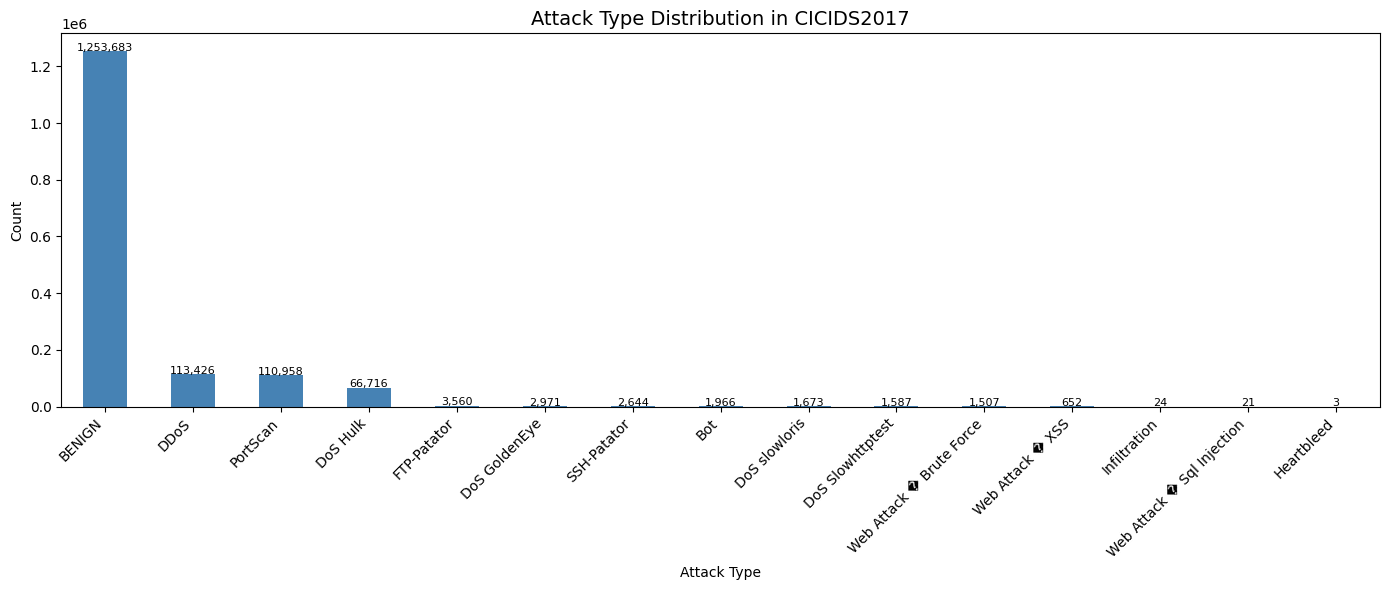

In [9]:
# Visualize label distribution
plt.figure(figsize=(14, 6))
ax = df[label_col].value_counts().plot(kind='bar', color='steelblue')
plt.title('Attack Type Distribution in CICIDS2017', fontsize=14)
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count labels
for i, v in enumerate(df[label_col].value_counts()):
    ax.text(i, v + 1000, f'{v:,}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## ⚙️ Cell 7: Data Preprocessing

In [10]:
# ============================================================
# 🔧 CONFIGURATION: Features to exclude (potential data leakage)
# ============================================================
# Set to True to remove port-based features that may cause overfitting
REMOVE_LEAKY_FEATURES = True

# Features that can cause data leakage or overfitting
LEAKY_FEATURES = [
    'Destination Port', 'Source Port',  # Port-specific attack signatures
    'Flow ID', 'Fwd Header Length.1'  # Duplicate/ID features
]
# ============================================================

def preprocess_data(df, label_col, remove_leaky=True):
    """Preprocess CICIDS2017 data for training."""
    print("⚙️ Preprocessing data...")

    # Separate features and labels
    y = df[label_col].copy()
    X = df.drop(columns=[label_col])

    # Keep only numeric columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[numeric_cols]
    print(f"  → {len(numeric_cols)} numeric features")

    # Remove potentially leaky features
    if remove_leaky:
        leaky_found = [col for col in LEAKY_FEATURES if col in X.columns]
        if leaky_found:
            X = X.drop(columns=leaky_found)
            print(f"  → Removed {len(leaky_found)} leaky features: {leaky_found}")

    # Remove columns with all NaN
    X = X.dropna(axis=1, how='all')

    # Replace infinite values with NaN, then fill with median
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    # Remove constant columns
    X = X.loc[:, X.apply(lambda col: col.nunique() > 1)]
    print(f"  → {X.shape[1]} features after cleaning")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print(f"  → {len(label_encoder.classes_)} classes")

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("  → Features scaled ✓")

    return X_scaled, y_encoded, X.columns.tolist(), label_encoder, scaler

# Preprocess with leaky feature removal
X, y, feature_names, label_encoder, scaler = preprocess_data(
    df, label_col, remove_leaky=REMOVE_LEAKY_FEATURES
)

print(f"\n✅ Final dataset: {X.shape[0]:,} samples × {X.shape[1]} features")
print(f"✅ Classes: {list(label_encoder.classes_)}")

⚙️ Preprocessing data...
  → 78 numeric features
  → Removed 2 leaky features: ['Destination Port', 'Fwd Header Length.1']
  → 68 features after cleaning
  → 15 classes
  → Features scaled ✓

✅ Final dataset: 1,561,391 samples × 68 features
✅ Classes: ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']


## ⚠️ Cell 7b: Check for Data Leakage Features

In [11]:
# Check for features that might cause data leakage
# These features often correlate too strongly with labels

print("⚠️ Checking for potential data leakage features...")
print("=" * 50)

# Known problematic features in CICIDS2017
suspicious_features = [
    'Flow ID', 'Source IP', 'Destination IP', 'Source Port', 
    'Destination Port', 'Timestamp', 'Protocol'
]

found_suspicious = []
for feat in suspicious_features:
    matching = [col for col in df.columns if feat.lower() in col.lower()]
    if matching:
        found_suspicious.extend(matching)
        print(f"⚠️ Found potentially leaky feature: {matching}")

if found_suspicious:
    print(f"\n📌 Recommendation: These features might leak information about attacks.")
    print("   They are excluded during preprocessing (non-numeric), but verify.")
else:
    print("✅ No obvious data leakage features found.")

# Check feature correlation with label (for numeric features only)
print("\n📊 Top features correlated with attack labels:")
numeric_df = df.select_dtypes(include=[np.number])
if label_col in df.columns:
    # Encode label temporarily
    temp_encoder = LabelEncoder()
    y_temp = temp_encoder.fit_transform(df[label_col])
    
    correlations = {}
    for col in numeric_df.columns:
        if col != label_col:
            try:
                corr = abs(np.corrcoef(numeric_df[col].fillna(0), y_temp)[0, 1])
                if not np.isnan(corr):
                    correlations[col] = corr
            except:
                pass
    
    # Sort by correlation
    sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:10]
    for feat, corr in sorted_corr:
        warning = "⚠️ VERY HIGH" if corr > 0.9 else "⚡ High" if corr > 0.7 else ""
        print(f"  {feat}: {corr:.4f} {warning}")

⚠️ Checking for potential data leakage features...
⚠️ Found potentially leaky feature: ['Destination Port']

📌 Recommendation: These features might leak information about attacks.
   They are excluded during preprocessing (non-numeric), but verify.

📊 Top features correlated with attack labels:
  PSH Flag Count: 0.3745 
  Min Packet Length: 0.2508 
  Bwd Packet Length Min: 0.2171 
  Init_Win_bytes_forward: 0.1452 
  Bwd Packets/s: 0.1343 
  URG Flag Count: 0.1173 
  Fwd IAT Std: 0.1069 
  Fwd Packet Length Min: 0.1058 
  Bwd Packet Length Std: 0.1041 
  Fwd Packet Length Mean: 0.0946 


## ✂️ Cell 8: Train-Test Split

In [12]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"📊 Training set: {X_train.shape[0]:,} samples")
print(f"📊 Test set: {X_test.shape[0]:,} samples")

# Check class distribution in train/test
print("\n📈 Class distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c:,} ({c/len(y_train)*100:.2f}%)")

📊 Training set: 1,249,112 samples
📊 Test set: 312,279 samples

📈 Class distribution in training set:
  BENIGN: 1,002,946 (80.29%)
  Bot: 1,573 (0.13%)
  DDoS: 90,741 (7.26%)
  DoS GoldenEye: 2,377 (0.19%)
  DoS Hulk: 53,373 (4.27%)
  DoS Slowhttptest: 1,269 (0.10%)
  DoS slowloris: 1,338 (0.11%)
  FTP-Patator: 2,848 (0.23%)
  Heartbleed: 2 (0.00%)
  Infiltration: 19 (0.00%)
  PortScan: 88,766 (7.11%)
  SSH-Patator: 2,115 (0.17%)
  Web Attack � Brute Force: 1,206 (0.10%)
  Web Attack � Sql Injection: 17 (0.00%)
  Web Attack � XSS: 522 (0.04%)


## 🚀 Cell 9: Train XGBoost Model

In [13]:
import xgboost as xgb

# Check XGBoost version and GPU availability (XGBoost 2.0+ syntax)
print(f"XGBoost version: {xgb.__version__}")

try:
    # Test GPU with XGBoost 2.0+ syntax
    test_model = xgb.XGBClassifier(tree_method='hist', device='cuda', n_estimators=1)
    print("✅ GPU support is available! Using device='cuda' with tree_method='hist'")
except Exception as e:
    print(f"⚠️ GPU not available, will use CPU. Error: {e}")

XGBoost version: 3.1.3
✅ GPU support is available! Using device='cuda' with tree_method='hist'


In [14]:
# XGBoost parameters optimized for Jetson Xavier NX
# Added regularization to prevent overfitting
# GPU acceleration enabled for GTX 1650Ti (XGBoost 2.0+ syntax)
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_),
    'max_depth': 5,  # Reduced from 6 to prevent overfitting
    'learning_rate': 0.05,  # Reduced for better generalization
    'n_estimators': 200,  # More trees with lower learning rate
    'min_child_weight': 5,  # Increased to prevent overfitting
    'subsample': 0.7,  # Reduced for regularization
    'colsample_bytree': 0.7,  # Reduced for regularization
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 1.0,  # L2 regularization
    'tree_method': 'hist',  # Use hist method
    'device': 'cuda',  # GPU acceleration (XGBoost 2.0+ syntax)
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1,
    'early_stopping_rounds': 20  # Stop if no improvement
}

print("🚀 Training XGBoost model with GPU acceleration (GTX 1650Ti)...")
print(f"Parameters: max_depth={xgb_params['max_depth']}, n_estimators={xgb_params['n_estimators']}")
print(f"Regularization: reg_alpha={xgb_params['reg_alpha']}, reg_lambda={xgb_params['reg_lambda']}")
print(f"GPU: tree_method={xgb_params['tree_method']}, device={xgb_params['device']}")

# Create and train model with early stopping
model = xgb.XGBClassifier(**xgb_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

print(f"\n✅ Training complete! Best iteration: {model.best_iteration}")

🚀 Training XGBoost model with GPU acceleration (GTX 1650Ti)...
Parameters: max_depth=5, n_estimators=200
Regularization: reg_alpha=0.1, reg_lambda=1.0
GPU: tree_method=hist, device=cuda
[0]	validation_0-mlogloss:1.93045	validation_1-mlogloss:1.93039
[1]	validation_0-mlogloss:1.76486	validation_1-mlogloss:1.76478
[2]	validation_0-mlogloss:1.62663	validation_1-mlogloss:1.62656
[3]	validation_0-mlogloss:1.50806	validation_1-mlogloss:1.50800
[4]	validation_0-mlogloss:1.40381	validation_1-mlogloss:1.40375
[5]	validation_0-mlogloss:1.31156	validation_1-mlogloss:1.31150
[6]	validation_0-mlogloss:1.22856	validation_1-mlogloss:1.22848
[7]	validation_0-mlogloss:1.15339	validation_1-mlogloss:1.15332
[8]	validation_0-mlogloss:1.08470	validation_1-mlogloss:1.08464
[9]	validation_0-mlogloss:1.02186	validation_1-mlogloss:1.02181
[10]	validation_0-mlogloss:0.96416	validation_1-mlogloss:0.96411
[11]	validation_0-mlogloss:0.91058	validation_1-mlogloss:0.91053
[12]	validation_0-mlogloss:0.86121	validatio

## 📉 Cell 9b: Learning Curves (Overfitting Detection)

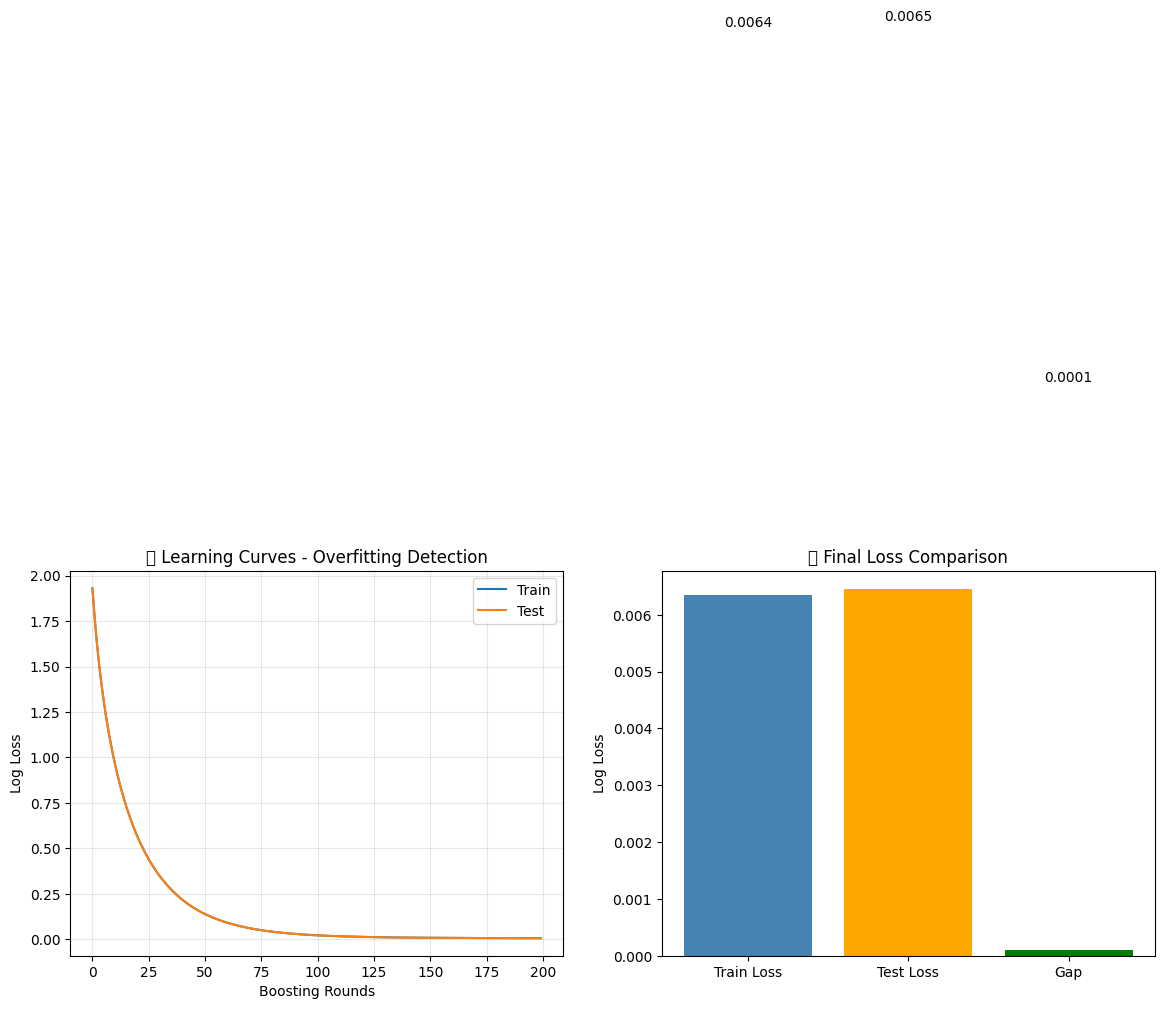


🔍 OVERFITTING ANALYSIS
Train Loss: 0.0064
Test Loss:  0.0065
Gap:        0.0001
✅ Model appears well-generalized (gap < 0.05)


In [15]:
# Plot learning curves to detect overfitting
results = model.evals_result()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training vs Validation Error
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

axes[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train')
axes[0].plot(x_axis, results['validation_1']['mlogloss'], label='Test')
axes[0].legend()
axes[0].set_xlabel('Boosting Rounds')
axes[0].set_ylabel('Log Loss')
axes[0].set_title('🔍 Learning Curves - Overfitting Detection')
axes[0].grid(True, alpha=0.3)

# Calculate gap between train and test error
train_loss = results['validation_0']['mlogloss'][-1]
test_loss = results['validation_1']['mlogloss'][-1]
gap = abs(test_loss - train_loss)

axes[1].bar(['Train Loss', 'Test Loss', 'Gap'], [train_loss, test_loss, gap], 
            color=['steelblue', 'orange', 'red' if gap > 0.1 else 'green'])
axes[1].set_title('📊 Final Loss Comparison')
axes[1].set_ylabel('Log Loss')

for i, v in enumerate([train_loss, test_loss, gap]):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Overfitting assessment
print("\n" + "=" * 50)
print("🔍 OVERFITTING ANALYSIS")
print("=" * 50)
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss:  {test_loss:.4f}")
print(f"Gap:        {gap:.4f}")

if gap < 0.05:
    print("✅ Model appears well-generalized (gap < 0.05)")
elif gap < 0.1:
    print("⚠️ Slight overfitting detected (0.05 < gap < 0.1)")
else:
    print("❌ Significant overfitting detected (gap > 0.1)")

## 🔄 Cell 9c: Cross-Validation (Robust Evaluation)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("🔄 Performing 5-Fold Cross-Validation with GPU...")
print("(This provides more reliable performance estimate)\n")

# Create a simpler model for CV (faster) with GPU (XGBoost 2.0+ syntax)
cv_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    max_depth=5,
    learning_rate=0.1,
    n_estimators=50,  # Fewer trees for faster CV
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',  # Use hist method
    device='cuda',  # GPU acceleration (XGBoost 2.0+ syntax)
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(cv_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("=" * 50)
print("📊 CROSS-VALIDATION RESULTS")
print("=" * 50)
print(f"\nFold Accuracies: {cv_scores}")
print(f"\nMean Accuracy:  {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"Std Deviation:  {cv_scores.std():.4f} (±{cv_scores.std()*100:.2f}%)")
print(f"95% CI:         [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")

# Compare with single split
print(f"\n📌 Single Split Accuracy: {accuracy:.4f}")
print(f"📌 CV Mean Accuracy:      {cv_scores.mean():.4f}")

if abs(accuracy - cv_scores.mean()) > 0.02:
    print("⚠️ Large difference suggests possible data leakage or overfitting!")
else:
    print("✅ Results consistent across folds - model is stable")

🔄 Performing 5-Fold Cross-Validation with GPU...
(This provides more reliable performance estimate)



## 📊 Cell 10: Evaluate Model

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("=" * 50)
print("📊 MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"\n🎯 Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall:    {recall:.4f}")
print(f"📌 F1-Score:  {f1:.4f}")

📊 MODEL EVALUATION RESULTS

🎯 Accuracy:  0.9984 (99.84%)
📌 Precision: 0.9982
📌 Recall:    0.9984
📌 F1-Score:  0.9982


In [ ]:
# Detailed classification report
print("\n" + "=" * 50)
print("📋 DETAILED CLASSIFICATION REPORT")
print("=" * 50)

# Get unique classes present in y_test to avoid mismatch
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
target_names_filtered = [label_encoder.classes_[i] for i in unique_classes]

print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names_filtered))


📋 DETAILED CLASSIFICATION REPORT
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    129208
                       Bot       0.83      0.82      0.83       202
                      DDoS       1.00      1.00      1.00     11324
             DoS GoldenEye       1.00      0.99      0.99       291
                  DoS Hulk       1.00      1.00      1.00      6674
          DoS Slowhttptest       0.96      0.99      0.98       158
             DoS slowloris       0.99      0.99      0.99       164
               FTP-Patator       1.00      1.00      1.00       353
              Infiltration       1.00      0.50      0.67         2
                  PortScan       0.99      1.00      1.00     11092
               SSH-Patator       1.00      1.00      1.00       273
  Web Attack � Brute Force       0.72      0.96      0.82       182
Web Attack � Sql Injection       0.00      0.00      0.00         2
          Web

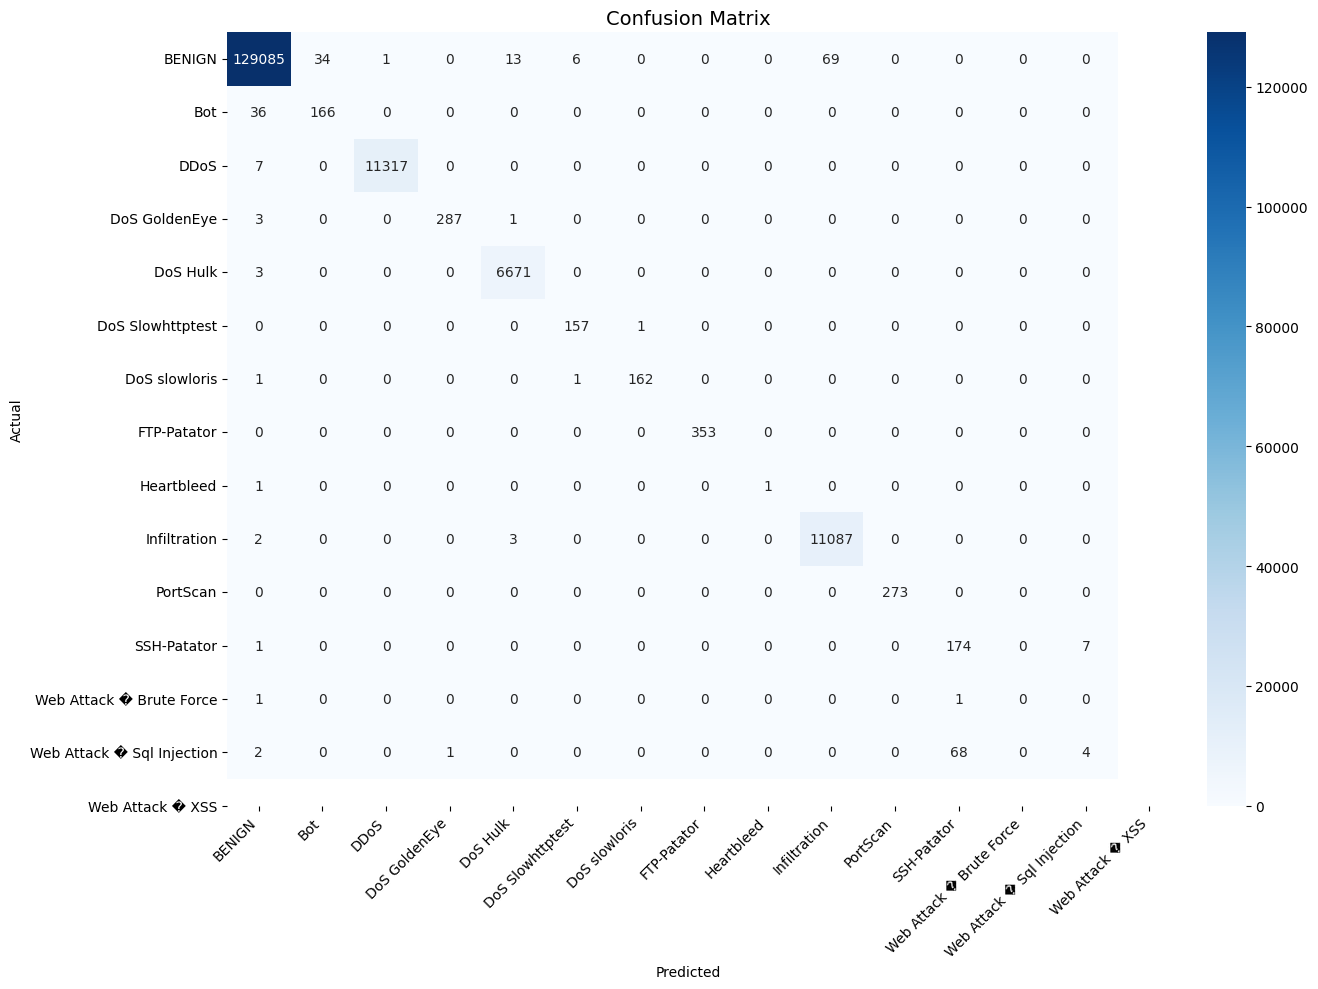

In [ ]:
# Confusion Matrix
plt.figure(figsize=(14, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 📈 Cell 11: Feature Importance

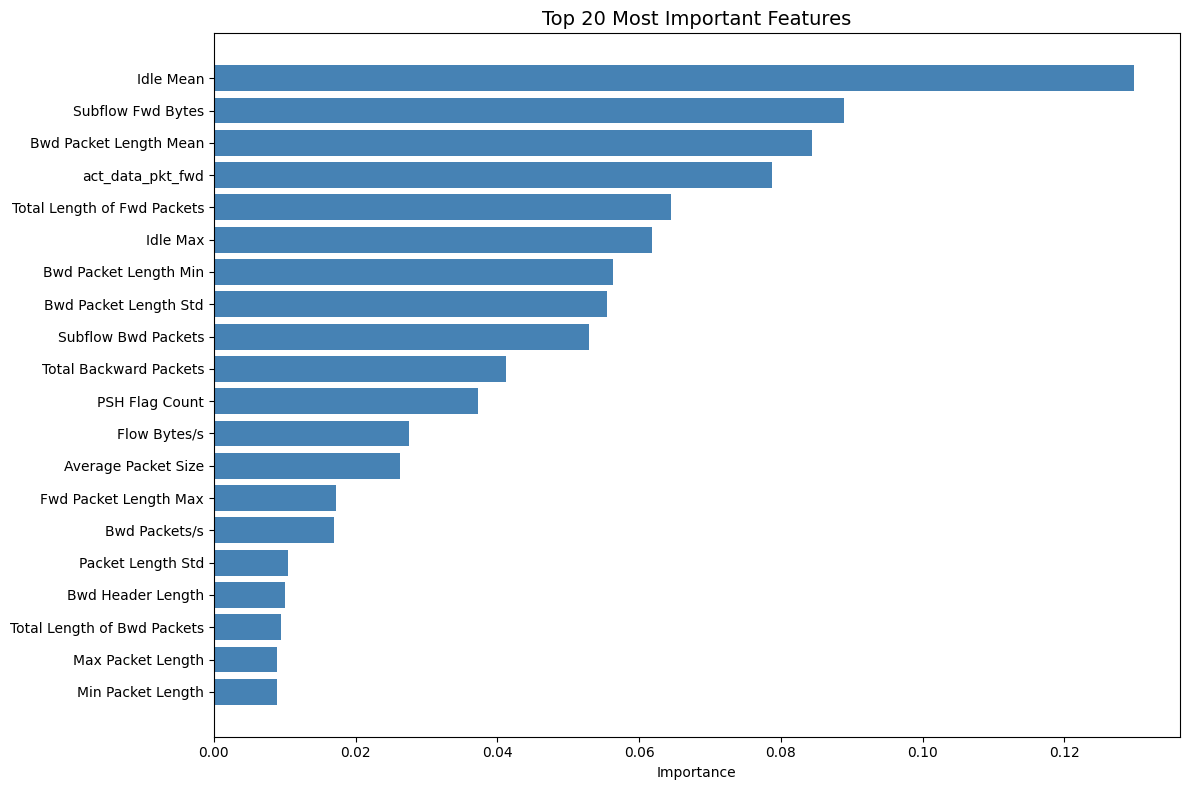


📊 Top 10 Features:
                    feature  importance
                  Idle Mean    0.129844
          Subflow Fwd Bytes    0.088936
     Bwd Packet Length Mean    0.084448
           act_data_pkt_fwd    0.078776
Total Length of Fwd Packets    0.064477
                   Idle Max    0.061821
      Bwd Packet Length Min    0.056381
      Bwd Packet Length Std    0.055478
        Subflow Bwd Packets    0.052943
     Total Backward Packets    0.041264


In [ ]:
# Get feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## 💾 Cell 12: Save Model and Artifacts

In [ ]:
# Create output directory in the training directory of the project
output_dir = '/home/pavan/Desktop/eRaksha/e-rakshak/training/models'
os.makedirs(output_dir, exist_ok=True)

# Save all artifacts
print("💾 Saving model artifacts...")

joblib.dump(model, f'{output_dir}/ids_xgboost_model.joblib')
print("  ✓ Model saved")

joblib.dump(scaler, f'{output_dir}/ids_scaler.joblib')
print("  ✓ Scaler saved")

joblib.dump(label_encoder, f'{output_dir}/ids_label_encoder.joblib')
print("  ✓ Label encoder saved")

joblib.dump(feature_names, f'{output_dir}/ids_feature_names.joblib')
print("  ✓ Feature names saved")

# Save metadata
metadata = {
    'model_type': 'XGBoost',
    'num_features': len(feature_names),
    'num_classes': len(label_encoder.classes_),
    'classes': list(label_encoder.classes_),
    'accuracy': float(accuracy),
    'f1_score': float(f1),
    'xgb_params': xgb_params
}
joblib.dump(metadata, f'{output_dir}/ids_metadata.joblib')
print("  ✓ Metadata saved")

# Show file sizes
print("\n📦 Model file sizes:")
for f in os.listdir(output_dir):
    size = os.path.getsize(f'{output_dir}/{f}') / (1024*1024)
    print(f"  {f}: {size:.2f} MB")

💾 Saving model artifacts...
  ✓ Model saved
  ✓ Scaler saved
  ✓ Label encoder saved
  ✓ Feature names saved
  ✓ Metadata saved

📦 Model file sizes:
  ids_feature_names.joblib: 0.00 MB
  ids_label_encoder.joblib: 0.00 MB
  ids_metadata.joblib: 0.00 MB
  ids_scaler.joblib: 0.00 MB
  ids_xgboost_model.joblib: 2.35 MB


In [ ]:
# # Zip all model files
# !cd /content && zip -r rakshak_ids_model.zip models/

# # Download
# from google.colab import files
# files.download('/content/rakshak_ids_model.zip')

# print("\n✅ Download complete!")
# print("Extract and copy to your Jetson Xavier NX.")

## 🧪 Cell 14: Test Inference

In [ ]:
import time

# Load saved model
output_dir = '/home/pavan/Desktop/eRaksha/e-rakshak/training/models'
loaded_model = joblib.load(f'{output_dir}/ids_xgboost_model.joblib')
loaded_encoder = joblib.load(f'{output_dir}/ids_label_encoder.joblib')

# Test predictions
print("🧪 Testing inference...\n")

test_samples = X_test[:5]
test_labels = y_test[:5]
predictions = loaded_model.predict(test_samples)

print("Sample Results:")
print("-" * 50)
for i, (pred, actual) in enumerate(zip(predictions, test_labels)):
    pred_label = loaded_encoder.classes_[pred]
    actual_label = loaded_encoder.classes_[actual]
    match = "✓" if pred == actual else "✗"
    print(f"Sample {i+1}: Predicted={pred_label}, Actual={actual_label} {match}")

# Measure inference time
num_samples = 1000
test_batch = X_test[:num_samples]

start_time = time.time()
_ = loaded_model.predict(test_batch)
end_time = time.time()

inference_time = (end_time - start_time) * 1000 / num_samples
print(f"\n⚡ Inference time: {inference_time:.3f} ms/sample")
print(f"⚡ Throughput: {1000/inference_time:.0f} samples/second")

🧪 Testing inference...

Sample Results:
--------------------------------------------------
Sample 1: Predicted=BENIGN, Actual=BENIGN ✓
Sample 2: Predicted=PortScan, Actual=PortScan ✓
Sample 3: Predicted=BENIGN, Actual=BENIGN ✓
Sample 4: Predicted=DDoS, Actual=DDoS ✓
Sample 5: Predicted=PortScan, Actual=PortScan ✓

⚡ Inference time: 0.023 ms/sample
⚡ Throughput: 44289 samples/second


# ✅ Training Complete!

## 📋 Next Steps:

### 1. Transfer to Jetson
```bash
scp rakshak_ids_model.zip user@<jetson-ip>:~/e-raksha/
```

### 2. Extract on Jetson
```bash
cd ~/e-raksha
unzip rakshak_ids_model.zip
mkdir -p models/ids
mv models/*.joblib models/ids/
```

### 3. Install Dependencies
```bash
pip install xgboost joblib scikit-learn
```

### 4. Use in RAKSHAK
```python
from core.ids_classifier import IDSClassifier

classifier = IDSClassifier(model_dir="models/ids")
result = classifier.classify(flow_data)

if result['is_attack']:
    print(f"Attack: {result['attack_type']}")
    print(f"Action: {result['recommended_action']}")
```